In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
import os

coherence_path = r"C:\Users\joshu\nice\testcodepearsoncoherence"
sys.path.append(coherence_path)
import coherence  
from coherence import field_field_coherence

def preprocess(data):
    data = detrend(data, axis=0)
    epsilon = 1e-9
    data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data

run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}


left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)


n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted

    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                left_input_LFP_attleft = left_input_LFP[left_indices][:, 100:350]
                right_input_LFP_attleft = right_input_LFP[left_indices][:, 100:350]
                attention_LFP_attleft = attention_LFP[left_indices][:, 100:350]

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attleft)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attleft)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attleft)

            if len(right_indices) >= 1:

                left_input_LFP_attright = left_input_LFP[right_indices][:, 100:350]
                right_input_LFP_attright = right_input_LFP[right_indices][:, 100:350]
                attention_LFP_attright = attention_LFP[right_indices][:, 100:350]

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attright)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attright)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attright)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)


for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])


for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])


##-----------------calculating the number of trials for each class pair----------------
n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


Dataset 1 loaded in 26.20 seconds
Dataset 1 processed in 1.43 seconds
Dataset 2 loaded in 5.70 seconds
Dataset 2 processed in 0.61 seconds
Dataset 4 loaded in 5.65 seconds
Dataset 4 processed in 0.50 seconds
Dataset 8 loaded in 8.50 seconds
Dataset 8 processed in 0.62 seconds
Dataset 14 loaded in 7.19 seconds
Dataset 14 processed in 0.88 seconds
Dataset 15 loaded in 7.20 seconds
Dataset 15 processed in 1.61 seconds
Dataset 20 loaded in 6.48 seconds
Dataset 20 processed in 0.85 seconds
Dataset 23 loaded in 6.44 seconds
Dataset 23 processed in 0.61 seconds
Total load time = 80.81 seconds


In [2]:

#-------------coherence calculation----------------
dt = 0.002
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']   #for coherence I have looked at the mean valuee for these bands
freq_ranges = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  # Actual frequency ranges


lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {f'{band}':  {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for band in bands} for class_right in classes_right} for class_left in classes_left} 


coh_means = copy.deepcopy(lr_split_structure)
coh_stdevs = copy.deepcopy(lr_split_structure)


for class_left in classes_left:
    coh_start = time.time()
    for class_right in classes_right: 

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    

        left_in_coh_leftatt, freq = field_field_coherence(
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            dt
        )
        right_in_coh_leftatt, freq = field_field_coherence(
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            dt
        )
          
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attleft'].append(
                np.mean(left_in_coh_leftatt[band_idx]))  #taking the mean across trials
            coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attleft'].append(
                np.mean(right_in_coh_leftatt[band_idx]))

            coh_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attleft'].append(
                np.std(left_in_coh_leftatt[band_idx], ddof=1))
            coh_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attleft'].append(
                np.std(right_in_coh_leftatt[band_idx], ddof=1))

    print(f"Class pair {class_left} {class_right} processed in {time.time() - coh_start:.2f} seconds")



for class_left in classes_left:
    coh_start = time.time()
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            continue        

        #for attention right condition:
        left_in_coh_rightatt, freq = field_field_coherence(
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            dt
        )
        right_in_coh_rightatt, freq = field_field_coherence(
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            dt
        )   

        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attright'].append(
                np.mean(left_in_coh_rightatt[band_idx]))  #taking the mean across trials
            coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attright'].append(
                np.mean(right_in_coh_rightatt[band_idx]))

            coh_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attright'].append(
                np.std(left_in_coh_rightatt[band_idx], ddof=1))
            coh_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attright'].append(
                np.std(right_in_coh_rightatt[band_idx], ddof=1))


    print(f"Class pair {class_left} {class_right} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - run_time
print(f"Total run time = {run_time:.2f} seconds")

c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Class pair 0 19 processed in 0.13 seconds
Class pair 1 19 processed in 0.03 seconds
Class pair 2 19 processed in 0.03 seconds
Class pair 3 19 processed in 0.05 seconds
Class pair 4 19 processed in 0.04 seconds
Class pair 5 19 processed in 0.04 seconds
Class pair 6 19 processed in 0.06 seconds
Class pair 7 19 processed in 0.07 seconds
Class pair 8 19 processed in 0.05 seconds
Class pair 9 19 processed in 0.09 seconds
Class pair 10 19 processed in 0.13 seconds
Class pair 11 19 processed in 0.09 seconds
Class pair 12 19 processed in 0.05 seconds
Class pair 13 19 processed in 0.03 seconds
Class pair 14 19 processed in 0.04 seconds
Class pair 15 19 processed in 0.05 seconds
Class pair 16 19 processed in 0.05 seconds
Class pair 17 19 processed in 0.05 seconds
Class pair 18 19 processed in 0.06 seconds
Class pair 19 19 processed in 0.06 seconds
Class pair 0 19 processed in 0.05 seconds
Class pair 1 19 processed in 0.06 seconds
Class pair 2 19 processed in 0.07 seconds
Class pair 3 19 processe

[np.float64(0.7988958001831338)]


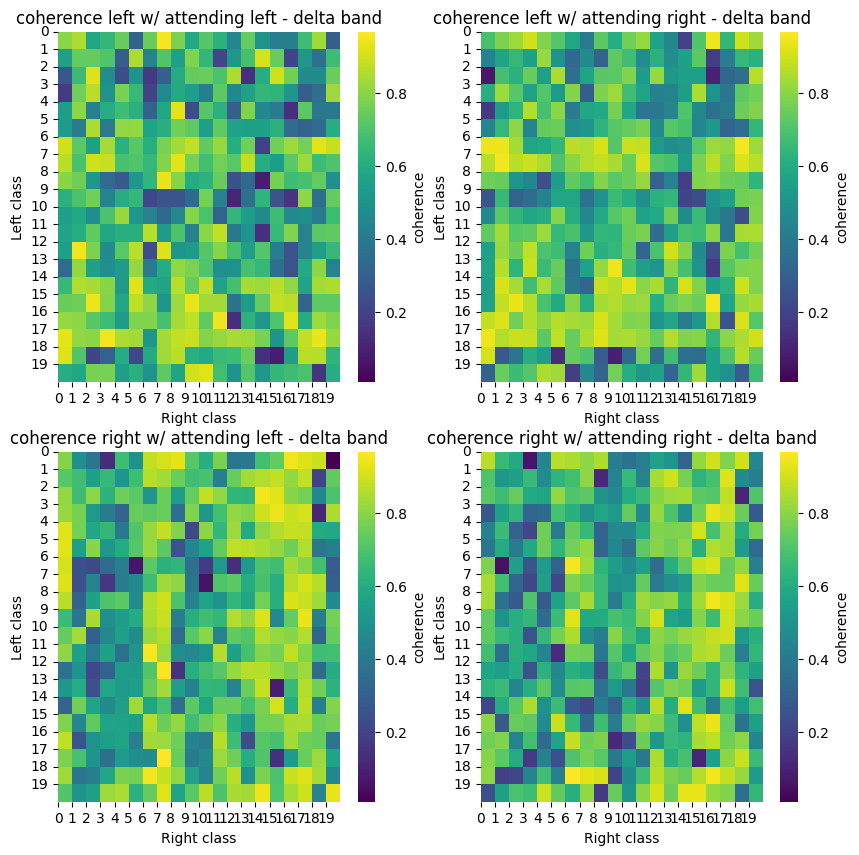

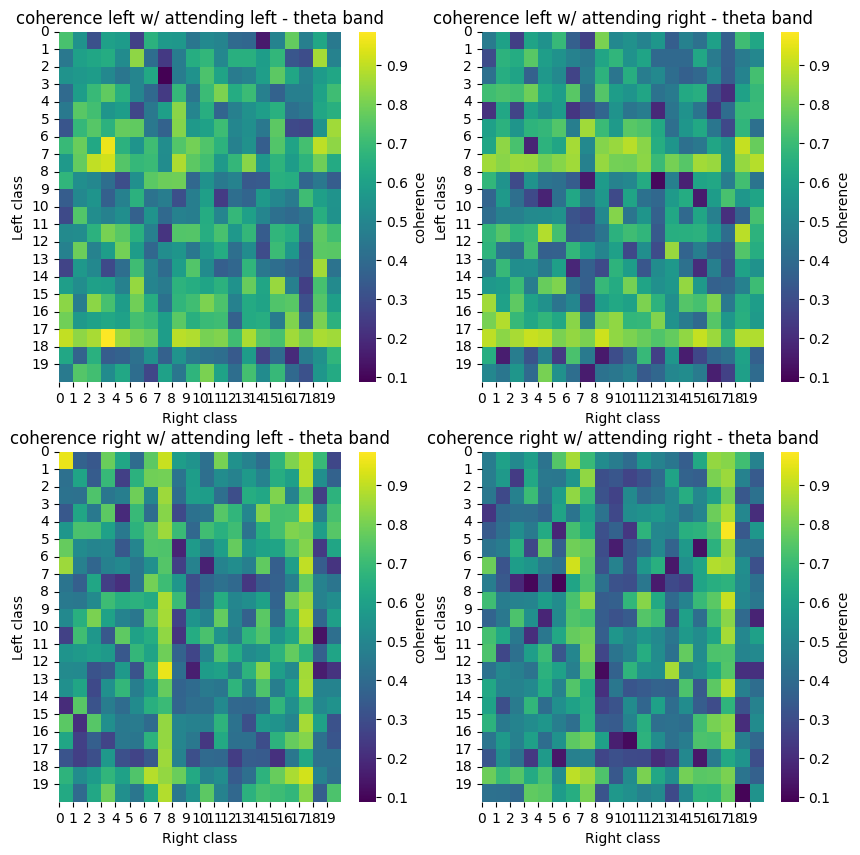

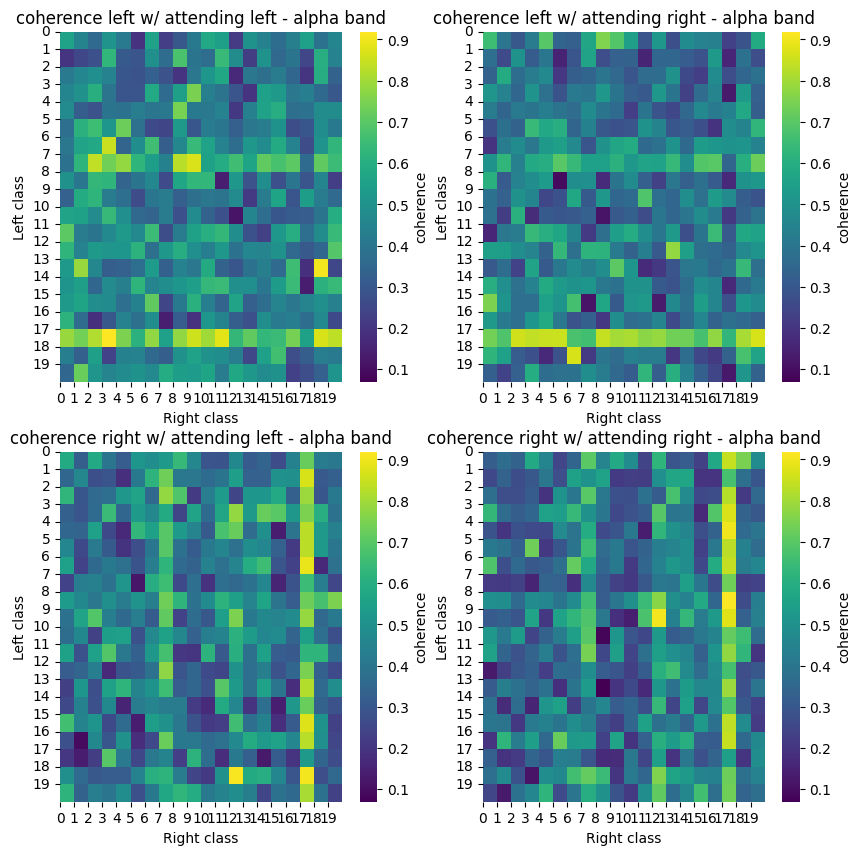

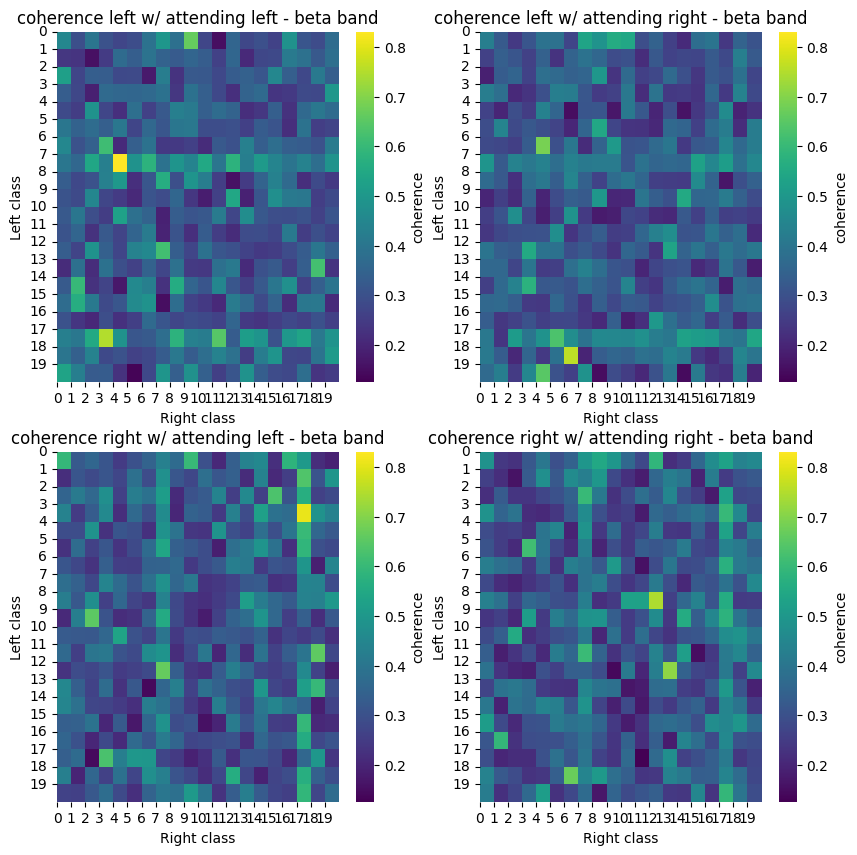

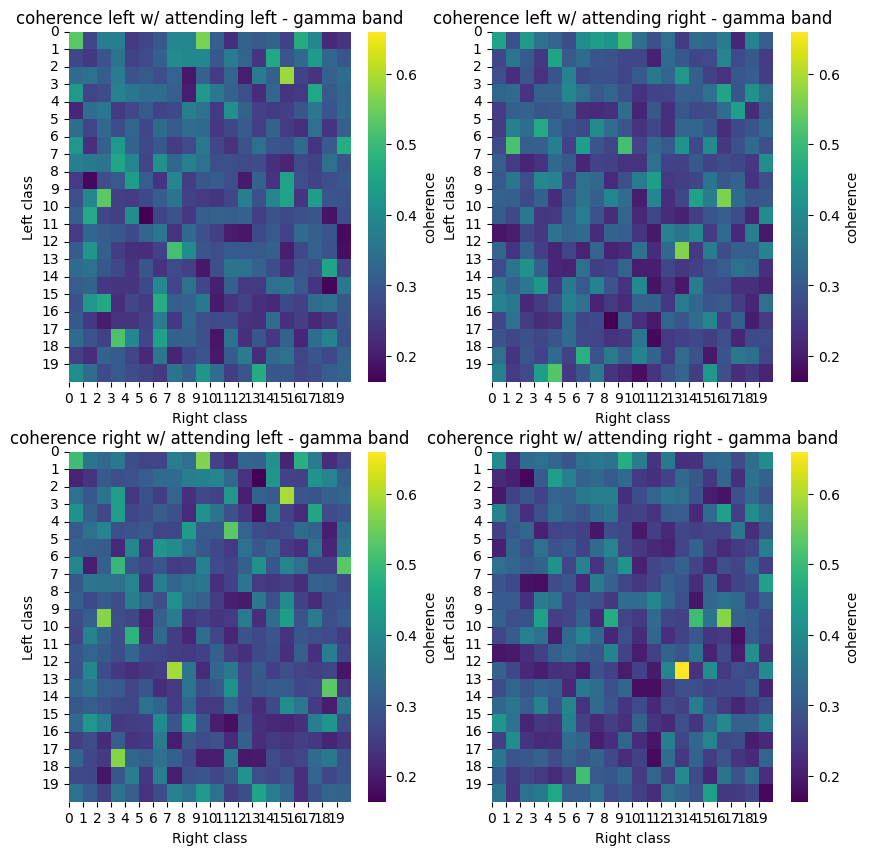

In [ ]:
#--------plotting the results-------------
results_to_plot =copy.deepcopy(lr_split_structure) 

for band in bands:
    for class_left in classes_left:
        for class_right in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key] = coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key]


def calculate_vmin_vmax(results_to_plot, classes_left, classes_right, band):
    vmax = np.max([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax

print(results_to_plot[f'left_class_{0}'][f'right_class_{0}']['delta']['left_attleft'])

vmin_delta, vmax_delta = calculate_vmin_vmax(results_to_plot, classes_left, classes_right, 'delta')
vmin_theta, vmax_theta = calculate_vmin_vmax(results_to_plot, classes_left, classes_right, 'theta')
vmin_alpha, vmax_alpha = calculate_vmin_vmax(results_to_plot, classes_left, classes_right, 'alpha')
vmin_beta, vmax_beta = calculate_vmin_vmax(results_to_plot, classes_left, classes_right, 'beta')
vmin_gamma, vmax_gamma = calculate_vmin_vmax(results_to_plot, classes_left, classes_right, 'gamma')


def plot_4_heat(data, band, vmin, vmax):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attleft'][0] for class_right in classes_right] for class_left in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'coherence'}, vmin = vmin, vmax = vmax)
    ax[0,0].set_xticks(np.arange(0, 20))
    ax[0,0].set_yticks(np.arange(0, 20))
    ax[0,0].set_xticklabels(classes_right)
    ax[0,0].set_yticklabels(classes_left)
    ax[0,0].set_xlabel('Right class')
    ax[0,0].set_ylabel('Left class')
    ax[0,0].set_title(f'coherence left w/ attending left - {band} band')

    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attleft'][0] for class_right in classes_right] for class_left in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'coherence'}, vmin = vmin, vmax = vmax)
    ax[1,0].set_xticks(np.arange(0, 20))
    ax[1,0].set_yticks(np.arange(0, 20))
    ax[1,0].set_xticklabels(classes_right)
    ax[1,0].set_yticklabels(classes_left)
    ax[1,0].set_xlabel('Right class')
    ax[1,0].set_ylabel('Left class')
    ax[1,0].set_title(f'coherence right w/ attending left - {band} band')

    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attright'][0] for class_right in classes_right] for class_left in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'coherence'}, vmin = vmin, vmax = vmax)
    ax[0,1].set_xticks(np.arange(0, 20))
    ax[0,1].set_yticks(np.arange(0, 20))
    ax[0,1].set_xticklabels(classes_right)
    ax[0,1].set_yticklabels(classes_left)
    ax[0,1].set_xlabel('Right class')
    ax[0,1].set_ylabel('Left class')
    ax[0,1].set_title(f'coherence left w/ attending right - {band} band')

    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attright'][0] for class_right in classes_right] for class_left in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'coherence'}, vmin = vmin, vmax = vmax)
    ax[1,1].set_xticks(np.arange(0, 20))
    ax[1,1].set_yticks(np.arange(0, 20))
    ax[1,1].set_xticklabels(classes_right)
    ax[1,1].set_yticklabels(classes_left)
    ax[1,1].set_xlabel('Right class')
    ax[1,1].set_ylabel('Left class')
    ax[1,1].set_title(f'coherence right w/ attending right - {band} band')

    plt.show()

plot_4_heat(results_to_plot, 'delta', vmin_delta, vmax_delta)
plot_4_heat(results_to_plot, 'theta',  vmin_theta, vmax_theta)
plot_4_heat(results_to_plot, 'alpha', vmin_alpha, vmax_alpha)
plot_4_heat(results_to_plot, 'beta', vmin_beta, vmax_beta)
plot_4_heat(results_to_plot, 'gamma', vmin_gamma, vmax_gamma)

In [4]:
for class_left in classes_left:
    for class_right in classes_right:
        for band in bands:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key] = coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key]


lowest_classes = lowest_classes = [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7))]

results_to_plot_low = copy.deepcopy(lr_split_structure)


for class_left in classes_left:
    for class_right in classes_right:
        if (class_left, class_right) in lowest_classes:
            for band in bands:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key] = coh_means[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key]
        else:   #if not in lowest classes, set to -
            for band in bands:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}'][band][key] = -1

print(np.array(results_to_plot))
print(np.array(results_to_plot_low))
                


{'left_class_0': {'right_class_0': {'delta': {'left_attleft': [np.float64(0.6001990015602297)], 'right_attleft': [np.float64(0.9596513190005388)], 'left_attright': [np.float64(0.39917945961111945)], 'right_attright': [np.float64(0.2323241159894738)]}, 'theta': {'left_attleft': [np.float64(0.6282147365229815)], 'right_attleft': [np.float64(0.9842969908915781)], 'left_attright': [np.float64(0.4067380342699044)], 'right_attright': [np.float64(0.3187491698256689)]}, 'alpha': {'left_attleft': [np.float64(0.7550601266324231)], 'right_attleft': [np.float64(0.4896380128052808)], 'left_attright': [np.float64(0.6444889203727575)], 'right_attright': [np.float64(0.30725186368827695)]}, 'beta': {'left_attleft': [np.float64(0.6087899432731986)], 'right_attleft': [np.float64(0.5861878697230276)], 'left_attright': [np.float64(0.4570671613502993)], 'right_attright': [np.float64(0.5104180438653736)]}, 'gamma': {'left_attleft': [np.float64(0.7046338344442304)], 'right_attleft': [np.float64(0.822870708400

Below I plot some histograms, the hope would be that the mean coherence would be larger between left/competition layer than right when attending left, and visa versa for attending right. If not, would hope that perhaps the inputs with the least pearson correlation would be displaced in this direction. 

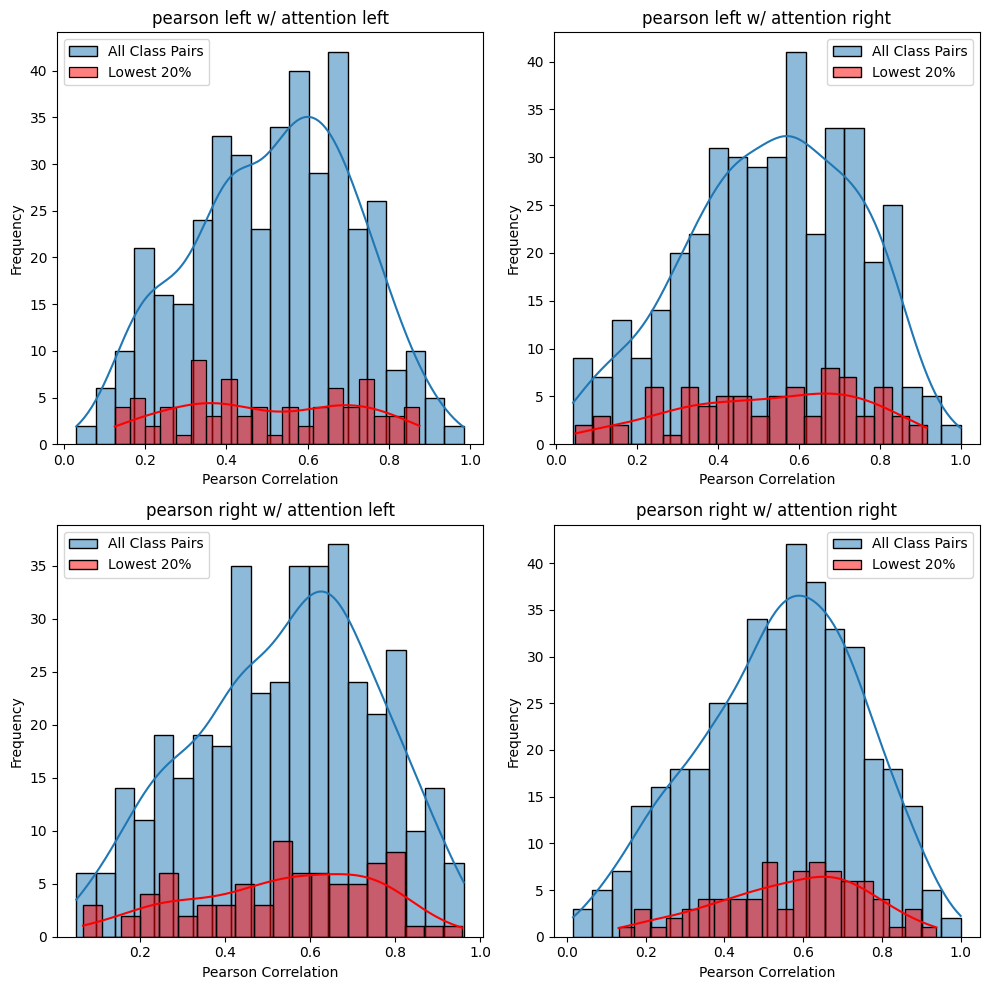

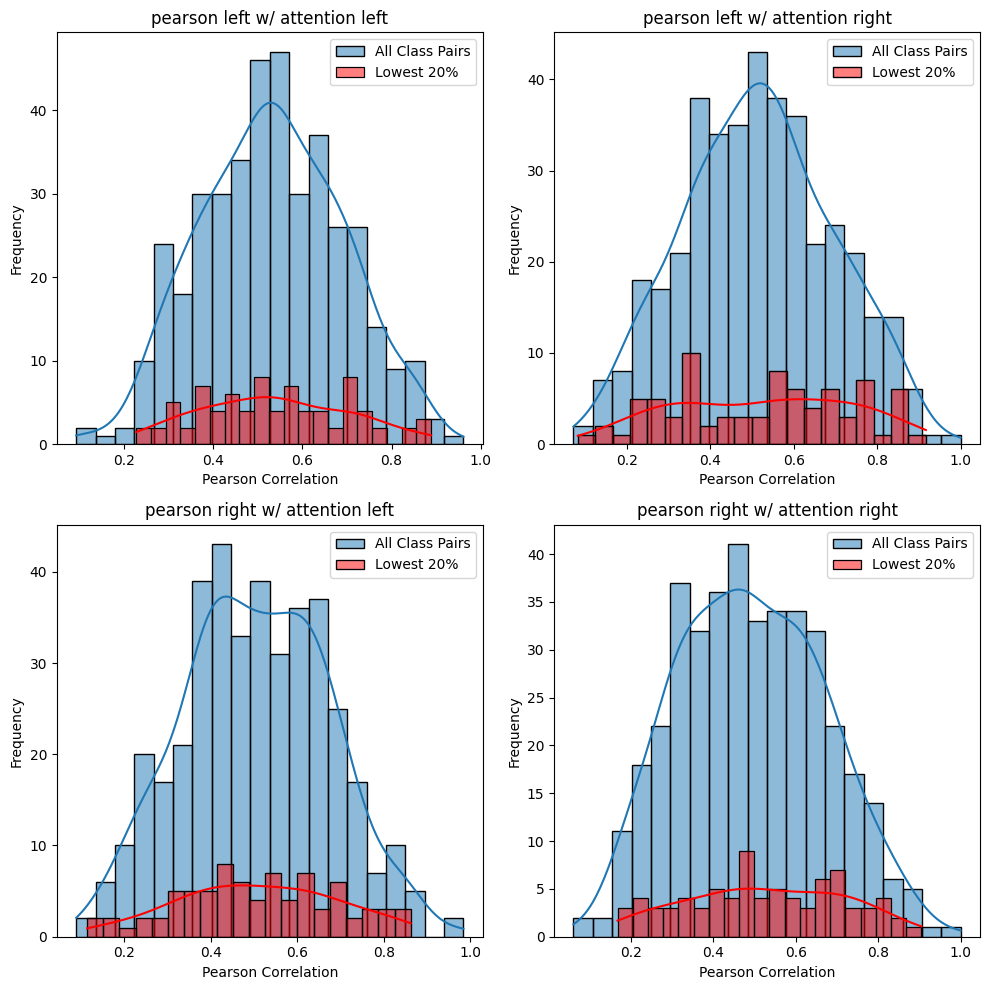

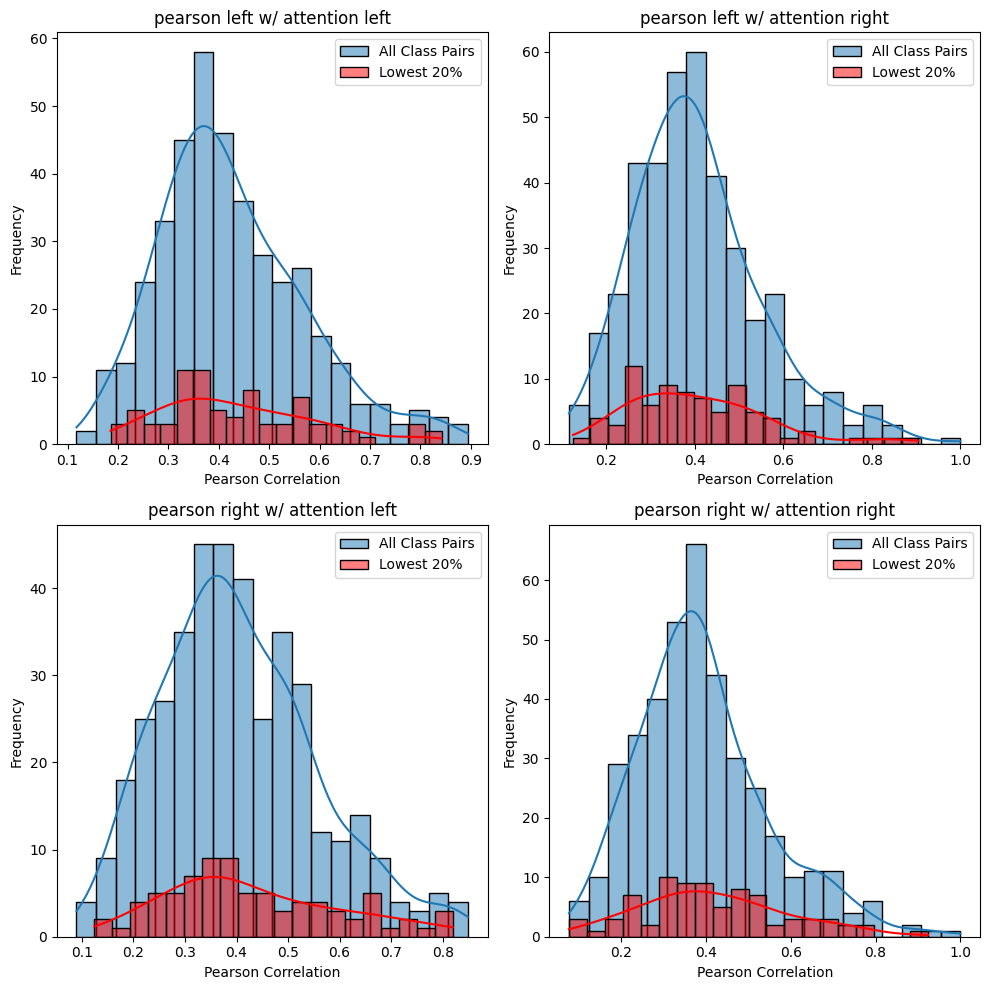

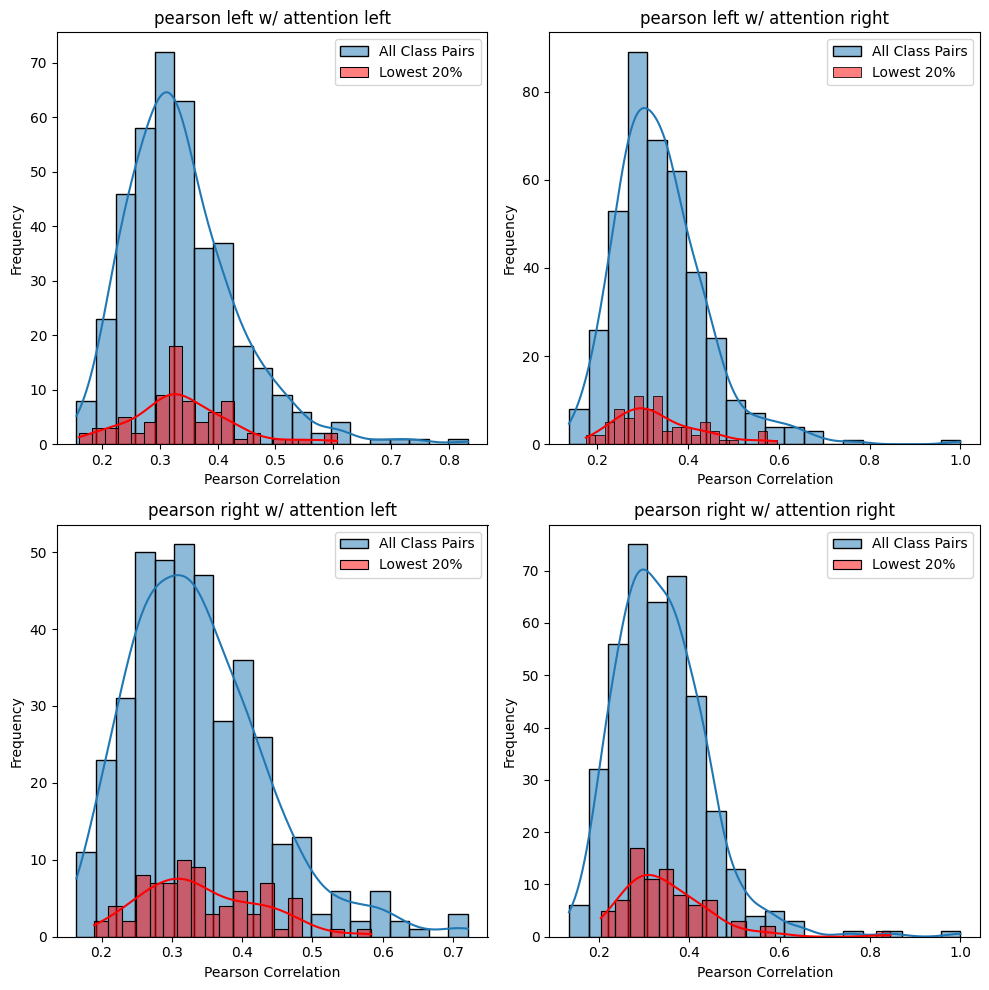

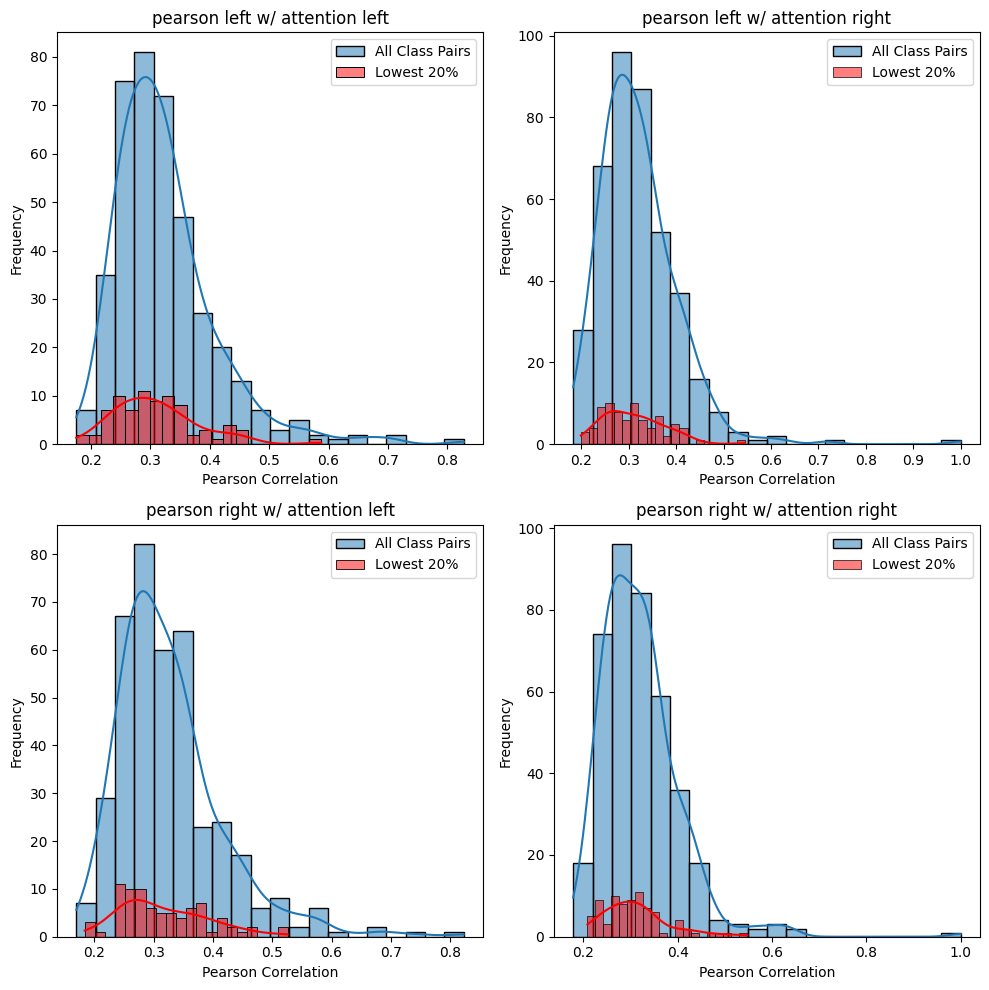

In [5]:
def plot_histograms(data, datalow, band):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    # Flatten the extracted wSMI values into 1D lists before plotting
    hist_values_all = [data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attleft']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attleft']
                        for class_left in classes_left for class_right in classes_right if datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attleft'] != -1]
    sns.histplot(np.array(hist_values_all), ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[0, 0], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[0,0].set_title('pearson left w/ attention left')
    ax[0,0].set_xlabel('Pearson Correlation')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].legend()

    # Repeat for the other plots
    hist_values_all = [data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attleft']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attleft']
                        for class_left in classes_left for class_right in classes_right if datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attleft'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[1, 0], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[1,0].set_title('pearson right w/ attention left')
    ax[1,0].set_xlabel('Pearson Correlation')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].legend()

    hist_values_all = [data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attright']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attright']
                        for class_left in classes_left for class_right in classes_right if datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['left_attright'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[0, 1], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[0,1].set_title('pearson left w/ attention right')
    ax[0,1].set_xlabel('Pearson Correlation')
    ax[0,1].set_ylabel('Frequency')
    ax[0,1].legend()

    hist_values_all = [data[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attright']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attright']
                        for class_left in classes_left for class_right in classes_right if datalow[f'left_class_{class_left}'][f'right_class_{class_right}'][band]['right_attright'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[1, 1], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[1,1].set_title('pearson right w/ attention right')
    ax[1,1].set_xlabel('Pearson Correlation')
    ax[1,1].set_ylabel('Frequency')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

plot_histograms(results_to_plot, results_to_plot_low, 'delta')
plot_histograms(results_to_plot, results_to_plot_low, 'theta')
plot_histograms(results_to_plot, results_to_plot_low, 'alpha')
plot_histograms(results_to_plot, results_to_plot_low, 'beta')
plot_histograms(results_to_plot, results_to_plot_low, 'gamma')
